# Домашнее задание 3. VAE + NF + VAPNEV

### Загрузка данных
В данном задании вам предстоит снова работать с CelebA, но уже 64x64

Решением домашки является архив с использованными тетрадками/модулями, а так же .pdf файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)



In [1]:
#!g1.1
%pip install --upgrade --no-cache-dir gdown

import requests
# загрузите селебу вашим любимым способом
url = 'https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/utils/datasets/celeba.py'
open('celeba.py', 'wb').write(requests.get(url).content);
url = 'https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/data/celeba/list_attr_celeba.txt'
open('list_attr_celeba.txt', 'wb').write(requests.get(url).content);

Note: you may need to restart the kernel to use updated packages.


In [2]:
#!g1.1
from celeba import CelebADataset
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import trange, tqdm
import os 
from torch import nn

from torch import Tensor
from tqdm.notebook import tqdm 
from PIL import Image
from math import log, sqrt, pi

from torchvision.utils import make_grid


In [3]:
#!g1.1
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    t_normalize,
])

Мы будем использовать урезанный датасет (`crop=True`) для быстрой загрузки на диск.

Для обучения модели вам нужно будет загрузить полную версию датасета.

Перед отправкой тетрадки в автопроверку ***ПРОВЕРЬТЕ*** что `crop=True`, иначе ваше решение будет таймаутиться

In [4]:
#!g1.1
from random import randint

class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        return image

dataset = CelebaCustomDataset(
    transform=transform,
    attr_file_path='list_attr_celeba.txt',
    crop=False
)

img = dataset[0]
img.shape

torch.Size([3, 64, 64])

### Визуализация датасета

In [5]:
#!g1.1
def plot_img(img, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.axis('off')

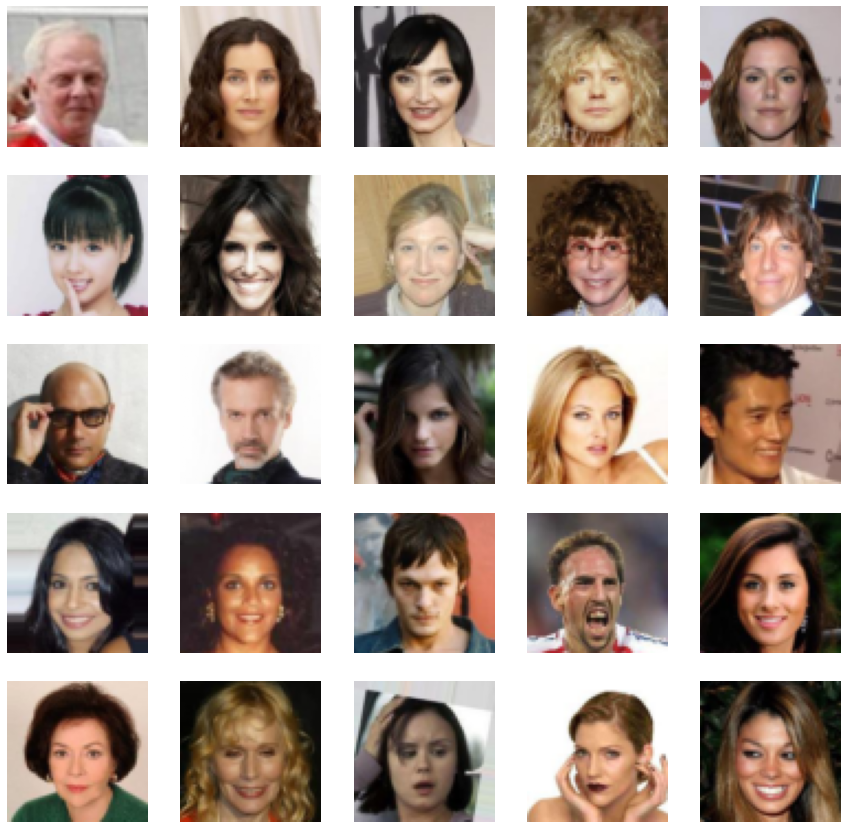

In [6]:
#!g1.1
plt.figure(figsize=(15, 15))

for i in range(25):
    img = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)
plt.show()

### Задача 1 (4/10 балла). Построить и обучить нормпоток на CelebA 64x64

Здесь нужно обучить нормпоток до нормального (трешхолды будут позже) качества, померить FID и Negative Log Likelihood и запомнить для будущего сравнения

Внутри потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации и все что вам приходит в голову. Но все что вы используете - напишите сами, без копипаста.

Можно использовать как и сверточные потоки (будут лучше, но сложнее писать), так и линейные (будут хуже), развернув селебу в один вектор.

В принципе можно использовать тот код который уже есть в репозитории курса, но он довольно плохой и неэффективный) Лучше написать свой


In [7]:
import torch
from torch import nn
from torch.nn import functional as F
from math import log, pi, exp
import numpy as np
from scipy import linalg as la
from scipy.stats import norm

from torch.distributions import Normal

logabs = lambda x: torch.log(torch.abs(x))

# Как в статье, было легко
class ActNorm(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        self.loc = nn.Parameter(torch.zeros(1, in_dim, 1, 1))
        self.scale = nn.Parameter(torch.ones(1, in_dim, 1, 1))
        
        self.init = False
        
    def forward(self, x):
        if not self.init:
            with torch.no_grad():
                self.loc.data.copy_(-x.mean([0, 2, 3]).reshape(1, -1, 1, 1))
                self.scale.data.copy_(1 / (x.std([0, 2, 3]) + 1e-6).reshape(1, -1, 1, 1))
            
            self.init = True

        logdet = x.shape[2] * x.shape[3] * (torch.log(torch.abs(self.scale))).sum()
        x = self.scale * (x + self.loc)
            
        return x, logdet
    
    def reverse(self, x):
        return x / self.scale - self.loc

# Ловушка, модель училась, а модуль не работал. 2 дня на дебаг :(
class InvConv1x1(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        self.conv = nn.Parameter(torch.empty(channels, channels).unsqueeze(2).unsqueeze(3))
        nn.init.orthogonal_(self.conv)
        
    def forward(self, x):
        out = F.conv2d(x, self.conv)
        
        logdet = (x.shape[2] * x.shape[3] * torch.slogdet(self.conv.squeeze())[1])
        
        return out, logdet
    
    def reverse(self, x):
        return F.conv2d(x, self.conv.squeeze().inverse().unsqueeze(2).unsqueeze(3))

# 4 дня на дебаг... Убил примерно 20 часов и 20 гпу часов на дебаг, помогла инициализация 1-2 сверток (последняя сразу нулилась как в статье) 
class AffineCoupling(nn.Module):
    def __init__(self, in_dim):
        super().__init__()

        self.NN = nn.Sequential(
            nn.Conv2d(in_dim // 2, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 1),
            nn.ReLU(),
            nn.Conv2d(512, in_dim, 3, 1, 1)
        )
        
        self.NN[0].weight.data.normal_(0, 0.05)
        self.NN[0].bias.data.zero_()
        self.NN[2].weight.data.normal_(0, 0.05)
        self.NN[2].bias.data.zero_()
        self.NN[4].weight.data.zero_()
        self.NN[4].bias.data.zero_()
        
    def forward(self, x):
        x_a, x_b = x.chunk(2, 1)
        
        log_s, t = self.NN(x_b).chunk(2, 1)
#         better conv in official repo
        s = F.sigmoid(log_s + 2)
        y_a = s * (x_a + t)
        y_b = x_b
        
        y = torch.cat([y_a, y_b], 1)
        
        logdet = (torch.log(s)).sum([1, 2, 3])
                
        return y, logdet
    
    def reverse(self, y):
        y_a, y_b = y.chunk(2, 1)
        
        log_s, t = self.NN(y_b).chunk(2, 1)
        s = F.sigmoid(log_s + 2)
        
        x_a = y_a / s - t
        x_b = y_b
        
        x = torch.cat([x_a, x_b], 1)
        
        return x

# Как в статье, было легко
class Flow(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        self.Net = nn.ModuleList([
            ActNorm(in_dim),
            InvConv1x1(in_dim),
            AffineCoupling(in_dim)
        ])

    def forward(self, x):
        for i in range(len(self.Net)):
            if i == 0:
                x, logdet = self.Net[i](x)
            else:
                x, new_logdet = self.Net[i](x)
                if new_logdet is not None:
                    logdet = new_logdet + logdet
            
        return x, logdet

    def reverse(self, x):
        for i in range(len(self.Net)):
            x = self.Net[2 - i].reverse(x)

        return x

# Дебагал свой пару часов, reverse не работал, пришлось часть подрезать из репа
class Block(nn.Module):
    def __init__(self, in_dim, n_flows, split=True):
        super().__init__()

        self.flows = nn.ModuleList(
            [Flow(4 * in_dim) for i in range(n_flows)]
        )

        self.split = split

        if split:
            prior_dims = [in_dim * 2, in_dim * 4]
        else:
            prior_dims = [in_dim * 4, in_dim * 8]
                        
        self.prior = nn.Conv2d(prior_dims[0], prior_dims[1], 3, 1, 1)
        self.prior.weight.data.zero_()
        self.prior.bias.data.zero_()

    def forward(self, x):
        b_size, n_channel, height, width = x.shape
        squeezed = x.view(b_size, n_channel, height // 2, 2, width // 2, 2)
        squeezed = squeezed.permute(0, 1, 3, 5, 2, 4)
        x = squeezed.contiguous().view(b_size, n_channel * 4, height // 2, width // 2)

        logdet = 0

        for flow in self.flows:
            x, logdet_new = flow(x)
            logdet = logdet + logdet_new

        if self.split:
            x, z_new = x.chunk(2, 1)
            mean, log_sd = self.prior(x).chunk(2, 1)
            log_p =  Normal(mean, torch.exp(log_sd)).log_prob(z_new).sum([1, 2, 3])
        else:
            zero = torch.zeros_like(x)
            mean, log_sd = self.prior(zero).chunk(2, 1)
            log_p =  Normal(mean, torch.exp(log_sd)).log_prob(x).sum([1, 2, 3])
            z_new = x

        return x, logdet, log_p, z_new

    def reverse(self, output, eps=None, resample=False):
        x = output

        if resample:
            if self.split:
                x = torch.cat([output, eps], 1)

            else:
                x = eps

        else:
            if self.split:
                mean, log_sd = self.prior(x).chunk(2, 1)
                z = mean + torch.exp(log_sd) * eps
                x = torch.cat([output, z], 1)

            else:
                zero = torch.zeros_like(x)
                mean, log_sd = self.prior(zero).chunk(2, 1)
                z = mean + torch.exp(log_sd) * eps
                x = z

        for flow in self.flows[::-1]:
            x = flow.reverse(x)

        b_size, n_channel, height, width = x.shape

        unsqueezed = x.view(b_size, n_channel // 4, 2, 2, height, width)
        unsqueezed = unsqueezed.permute(0, 1, 4, 2, 5, 3)
        unsqueezed = unsqueezed.contiguous().view(
            b_size, n_channel // 4, height * 2, width * 2
        )

        return unsqueezed

# Как в статье, было легко
class Glow(nn.Module):
    def __init__(self, in_dim, n_flows, n_blocks):
        super().__init__()

        self.block_list = nn.ModuleList(
            [Block(in_dim * 2**(i), n_flows) for i in range(n_blocks - 1)] +
            [Block(in_dim * 2**(n_blocks - 1), n_flows, split=False)]
        )

    def forward(self, x):        
        logdet, log_p = 0, 0
        z = []

        for block in self.block_list:
            x, logdet_new, log_p_new, z_new = block(x)
            
            z.append(z_new)
            logdet += logdet_new
            log_p += log_p_new

        return log_p, logdet, z

    def reverse(self, z, resample=False):
        x = self.block_list[-1].reverse(z[-1], z[-1], resample)
        
        
        for i in range(len(self.block_list) - 2, -1, -1):
            x = self.block_list[i].reverse(x, z[i], resample)
            
        return x

In [8]:
from gc import collect

collect()

15

In [9]:
# import wandb

# wandb.init(project="gan_hw3", entity="lemondrok2")

In [10]:
#!g1.1    
from tqdm.notebook import tqdm 
from torchvision.utils import make_grid

# Мой кастом лосс без констант медленнее сходится
def calc_loss(log_p, logdet, image_size, n_bins):
    # log_p = calc_log_p([z_list])
    n_pixel = image_size * image_size * 3

    loss = -log(n_bins) * n_pixel
    loss = loss + logdet + log_p

    return (
        (-loss / (log(2) * n_pixel)).mean(),
        (log_p / (log(2) * n_pixel)).mean(),
        (logdet / (log(2) * n_pixel)).mean(),
    )

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Glow(3, 8, 4).to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)


# Параллелизация не ест лямбду
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

dataset = CelebADataset(
    transform=transform,
    attr_file_path='list_attr_celeba.txt',
    crop=False
)
DL = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)
n = 20
z = [(torch.randn(z_size) * 0.7).to(device) for z_size in [[n, 6, 32, 32], [n, 12, 16, 16], [n, 24, 8, 8], [n, 96, 4, 4]]]

# Без бинаризации учится медленнее
n_bits = 4
quant_bins =  2.0 ** n_bits
n_bins = quant_bins
num_epochs = 16

# step = 0

# for i in tqdm(range(num_epochs), position=0, leave=True):
#     for iteration, (image, _) in enumerate(tqdm(DL, position=1, leave=True)):
# #         image = t_invnormalize(image).to(device) * 255
#         image = (image).to(device) * 255
#         image = torch.floor(image / 2 ** (8 - n_bits))
#         image = image / n_bins - 0.5
                        
#         log_p_sum, logdet, z_out = model(image + torch.rand_like(image) / n_bins)
        
#         loss, log_p, log_det = calc_loss(log_p_sum, logdet.mean(), 64, quant_bins)
        
# #         loss = (-logdet.mean() - log_p_sum).mean()
        
#         opt.zero_grad()
#         loss.backward()
#         opt.step()
        
#         wandb.log({"loss": loss.item(), "log_p": log_p.item(), 'logdet': log_det.item()}, step=step)
#         step += 1

#         if iteration % 100 == 0:
#             with torch.no_grad():
#                 zaza = model.reverse(z).cpu().data
#                 zozi = model.reverse(z_out, True).cpu().data
                
#                 plt.figure(figsize=(15, 15))
#                 x_show = make_grid(torch.cat([zaza[:16], image[:8].cpu().data, zozi[:8]], dim=0), nrow=8, normalize=False)
#                 plot_img(2 * x_show, t_invnormalize)
#                 wandb.log({"images": plt}, step=step)
# #                 plt.show()
    
#                 torch.save(model, 'model')
            
#         if iteration % 12663 == 12662:
#             torch.save(model, 'model{}'.format(step))


## Генерация картинок и отчет для Glow

In [11]:
model = torch.load('model245008')

E:\programming\conda\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


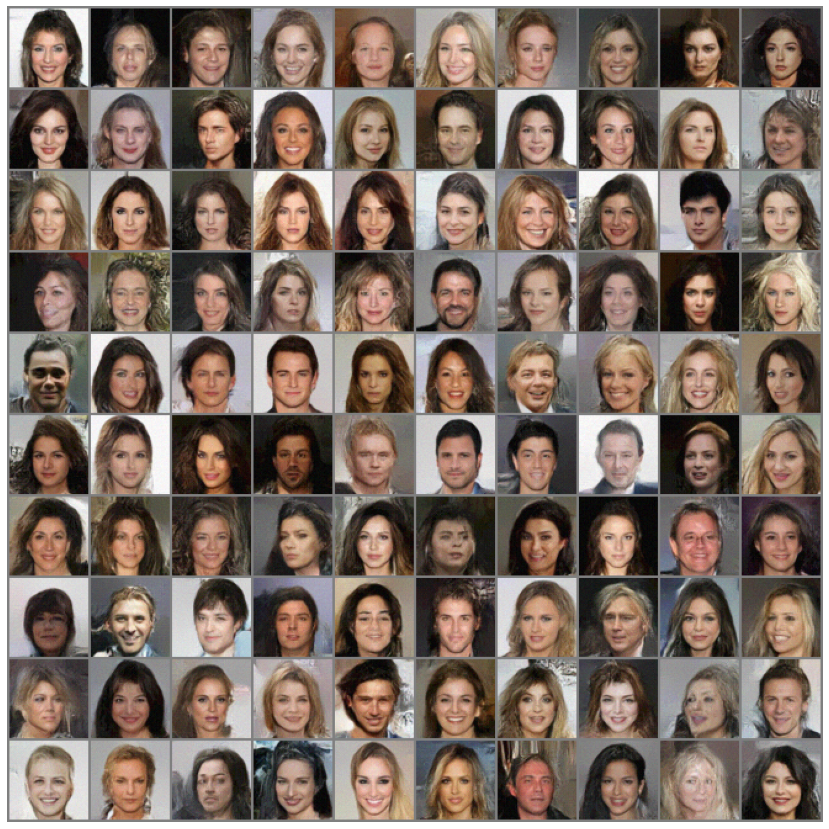

In [12]:
def generate_images(n, z=None):
    if z == None:
        z = [(torch.randn(z_size) * 0.7).to(device) for z_size in [[n, 6, 32, 32], [n, 12, 16, 16], [n, 24, 8, 8], [n, 96, 4, 4]]]
    
    with torch.no_grad():
        images = model.reverse(z).cpu().data
        
    plt.figure(figsize=(15, 15))
    x_show = make_grid(images, nrow=10, normalize=False)
    plot_img(2 * x_show, t_invnormalize)
    
generate_images(100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


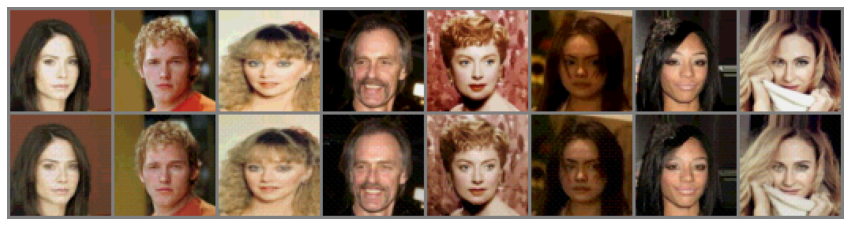

In [13]:
def reconstruct_images():
    with torch.no_grad():
        image, _ = next(iter(DL))
        
        image = (image).to(device) * 255
        image = torch.floor(image / 2 ** (8 - n_bits))
        image = image / n_bins - 0.5
        
        _, _, z = model(image)
        
        images = model.reverse(z).cpu().data
        
    plt.figure(figsize=(15, 15))
    x_show = make_grid(torch.cat([image.cpu().data[:8], images[:8]], dim=0), nrow=8, normalize=False)
    plot_img(2 * x_show, t_invnormalize)
    
reconstruct_images()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


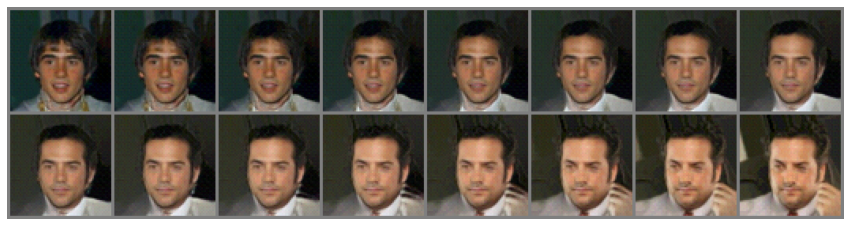

In [14]:
def latent_interpolation(n=16):
    new_z = [[] for i in range(4)]
    ans = []
    
    with torch.no_grad():
        image, _ = next(iter(DL))[:2]
        
        image = (image).to(device) * 255
        image = torch.floor(image / 2 ** (8 - n_bits))
        image = image / n_bins - 0.5
        
        _, _, z = model(image)
        
        
        for i in range(n):
            alpha = i / (n - 1)
            
            for j in range(4):
                new_z[j].append((1 - alpha) * z[j][0] + alpha * z[j][1])
                                
        for j in range(4):
            new_z[j] = torch.stack(new_z[j], dim=0)
                            
        images = model.reverse(new_z).cpu().data
        
    plt.figure(figsize=(15, 15))
    x_show = make_grid(images, nrow=n//2, normalize=False)
    plot_img(2 * x_show, t_invnormalize)
    plt.show()
        
    
        
latent_interpolation()

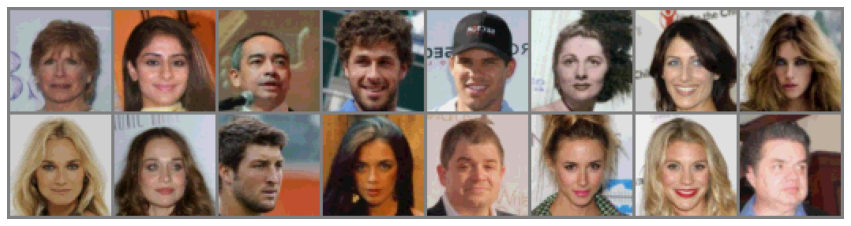

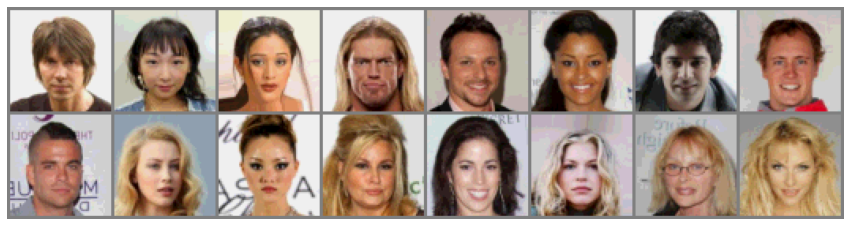

In [15]:
def explore_z(path):
    images = []
    z_s = []
    
    with torch.no_grad():
        while True:
            image, _ = next(iter(DL))

            image = (image).to(device) * 255
            image = torch.floor(image / 2 ** (8 - n_bits))
            image = image / n_bins - 0.5

            _, _, z = model(image)

            for i in range(4):
                z[i] = z[i].reshape(z[i].shape[0], -1)
                
            z = torch.cat(z, dim=1)

            if len(images) == 0:
                images = image.cpu().data
                z_s = z.cpu().data
            else:
                images = torch.cat([images, image.cpu().data], dim=0)
                z_s = torch.cat([z_s, z.cpu().data], dim=0)
            
            if images.shape[0] > 200:
                break
                
        image = transform(Image.open(path)).unsqueeze(0)
                
        image = (image * 255.)[:, :3].to(device)
        image = torch.floor(image / 2 ** (8 - n_bits))
        image = image / n_bins - 0.5
        
        _, _, z = model(image)
        
        for i in range(4):
            z[i] = z[i].reshape(z[i].shape[0], -1)

        z = torch.cat(z, dim=1).cpu().data
        
        z_s = ((z_s - z[0])**2).sum(dim=1)
        
    kek = images[z_s.argsort()[:16]]
                
    plt.figure(figsize=(15, 15))
    x_show = make_grid(kek, nrow=8, normalize=False)
    plot_img(2 * x_show, t_invnormalize)
    plt.show()
        
explore_z('E:/programming/hse/GM/last_hw/111.png')
explore_z('E:/programming/hse/GM/last_hw/222.png')


## first FID

In [16]:
def generate_images_output(n, z=None):
    for j in range(5):
        z = [(torch.randn(z_size) * 0.6).to(device) for z_size in [[n, 6, 32, 32], [n, 12, 16, 16], [n, 24, 8, 8], [n, 96, 4, 4]]]
        
        with torch.no_grad():
            images = model.reverse(z).cpu().data
        
        for i, image in enumerate(images):
            utils.save_image(
                image.cpu().data,
                "E:/programming/hse/GM/last_hw/kok/{}.png".format(i + j * 1000),
                normalize=True,
                range=(-0.5, 0.5)
            )
        
# 500 samples
# generate_images_output(100)

# from fid_score import fid_score
# fid = fid_score.FidScore(['E:/programming/hse/GM/last_hw/data/celeba/img_align_celeba', 'E:/programming/hse/GM/last_hw/kok'], 'cuda', 16)
# score = fid.calculate_fid_score()

score = 152.27231185893982
score

152.27231185893982

## second FID

In [17]:
from torchmetrics.image.fid import FrechetInceptionDistance

def generate_images_returned(n, z=None):
    z = [(torch.randn(z_size) * 0.5).to(device) for z_size in [[n, 6, 32, 32], [n, 12, 16, 16], [n, 24, 8, 8], [n, 96, 4, 4]]]

    with torch.no_grad():
        images = model.reverse(z).cpu().data

    return torch.clip(images + 0.5, 0, 1)

# 500 samples
# real = next(iter(DataLoader(dataset, batch_size=500, shuffle=True)))[0]
# fake = generate_images_returned(500)

# fid = FrechetInceptionDistance(feature=64)
# fid.update(torch.floor(real * 255).type(torch.uint8), real=True)
# fid.update(torch.floor(fake * 255).type(torch.uint8), real=False)
# score = fid.compute()

score = 3.7805
score

3.7805

### Задача 2 (2/10 балла). Построить и обучить VAE на CelebA 64x64

Здесь нужно обучить VAE до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

Ради интереса, ваше вае тоже можно потестировать на маленьких датасетах


In [18]:
#!g1.1

class VAE(nn.Module):
    def __init__(self, ):
        super(VAE, self).__init__()

        l_dim = 64

        dims = [3, 32, 64, 128, 256, 512]
        self.encoder = nn.Sequential(
            *[
                nn.Sequential(nn.Conv2d(dims[i], dims[i + 1], kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(dims[i + 1]),
                nn.LeakyReLU()) for i in range(len(dims) - 1)
            ] + [nn.Flatten()]
        )

        self.enc_mu, self.enc_sigma = nn.Linear(dims[-1] * 4, l_dim), nn.Linear(dims[-1] * 4, l_dim)
        self.from_latent = nn.Linear(l_dim, dims[-1] * 4)

        self.decoder = nn.Sequential(
            *[
                nn.Sequential(nn.ConvTranspose2d(dims[i], dims[i - 1], kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(dims[i - 1]),
                nn.LeakyReLU()) for i in range(len(dims) - 1, 1, -1)
            ]
        )

        self.kekw = nn.Sequential(
            nn.ConvTranspose2d(dims[1], dims[1], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(dims[1]),
            nn.LeakyReLU(),
            nn.Conv2d(dims[1], dims[0], 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)

        mu, sigma = self.enc_mu(enc), self.enc_sigma(enc)

        std = torch.exp(sigma / 2)
        z = mu + std * torch.randn_like(std)

        y = self.kekw(self.decoder(self.from_latent(z).reshape((x.shape[0], -1, 2, 2))))
        return y, z, mu, std
    
    def sample(self, z):
        y = self.kekw(self.decoder(self.from_latent(z).reshape((z.shape[0], -1, 2, 2))))
        
        return y

In [19]:
#!g1.1

from torch.utils.data import DataLoader 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

m1 = VAE().to(device)

transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    t_normalize,
])

dataset = CelebaCustomDataset(
    transform=transform,
    attr_file_path='list_attr_celeba.txt',
    crop=False
)

img = dataset[0]
img.shape

DL = DataLoader(dataset, batch_size=128)

optimizer = torch.optim.Adam(m1.parameters(), 1e-3)

In [20]:
#!g1.1

from tqdm.notebook import tqdm

max_epoch = 20

# for epoch in tqdm(range(max_epoch)):
#     for images in tqdm(DL):
#         images = images.to(device)

#         a, b, mu, std = m1(images)

#         l_rec = F.mse_loss(a, images)
#         l_kl = (-0.5 * (1 + torch.log(std) - mu**2 - std).sum(dim=1)).mean(dim=0)
#         loss = l_rec + l_kl * 0.001


#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     with torch.no_grad():
#         z = torch.randn(100, 64).to(device)
#         images = m1.sample(z)
                
#         plt.figure(figsize=(15, 15))
#         x_show = make_grid(images.cpu().data, nrow=10, normalize=False)
#         plot_img(x_show, t_invnormalize)
#         plt.show()
        
#         images = next(iter(DL)).to(device)
#         a, b, mu, std = m1(images)
        
#         plt.figure(figsize=(15, 15))
#         x_show = make_grid(torch.cat([images[:8].cpu().data, a[:8].cpu().data], dim=0), nrow=8, normalize=False)
#         plot_img(x_show, t_invnormalize)
#         plt.show()
        
#         torch.save(m1, 'm1')
        

In [21]:
m1 = torch.load('m1').to(device)

## Генерация картинок и отчет для VAE

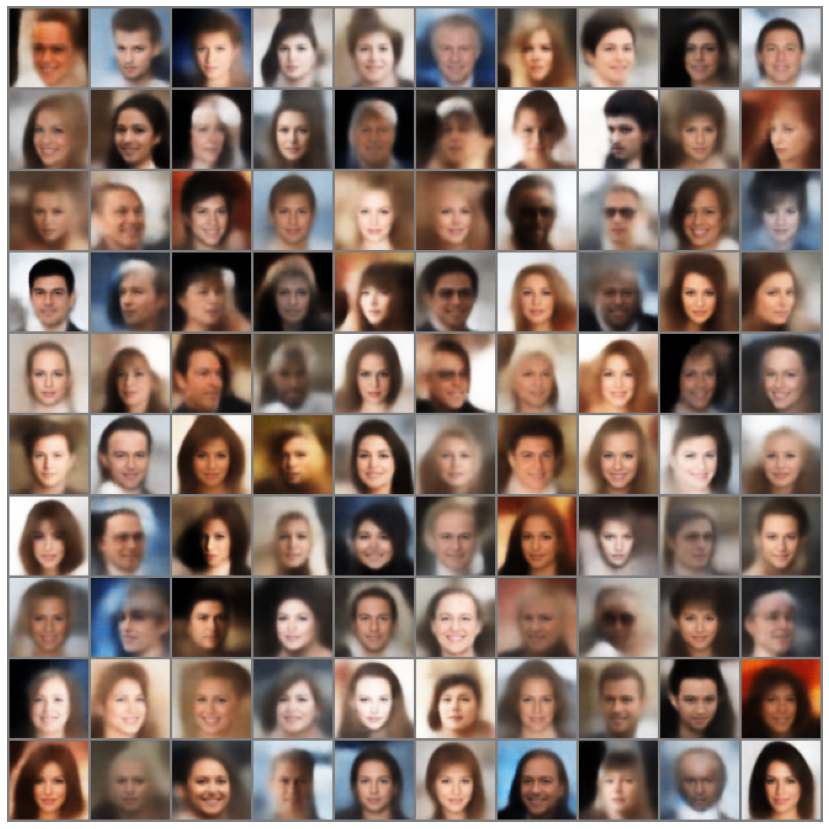

In [22]:
def generate_images(n, z=None):
    with torch.no_grad():
        z = torch.randn(n, 64).to(device)
        images = m1.sample(z).cpu().data
        
    plt.figure(figsize=(15, 15))
    x_show = make_grid(images, nrow=10, normalize=False)
    plot_img(x_show, t_invnormalize)
    plt.show()
    
generate_images(100)

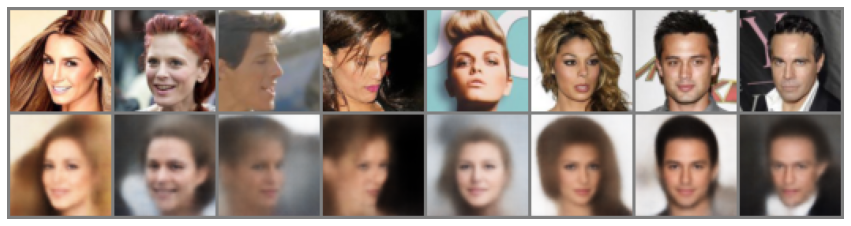

In [23]:
def reconstruct_images():
    with torch.no_grad():
        images = next(iter(DL)).to(device)
        a, b, mu, std = m1(images)        
        
    plt.figure(figsize=(15, 15))
    x_show = make_grid(torch.cat([images.cpu().data[:8], a.cpu().data[:8], ], dim=0), nrow=8, normalize=False)
    plot_img(x_show, t_invnormalize)
    plt.show()
    
reconstruct_images()

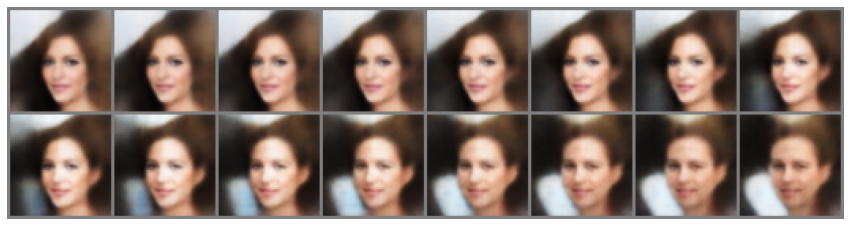

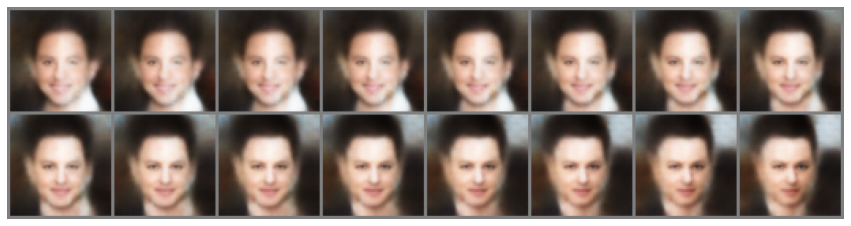

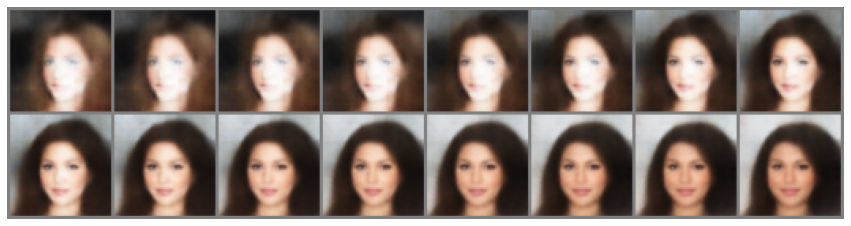

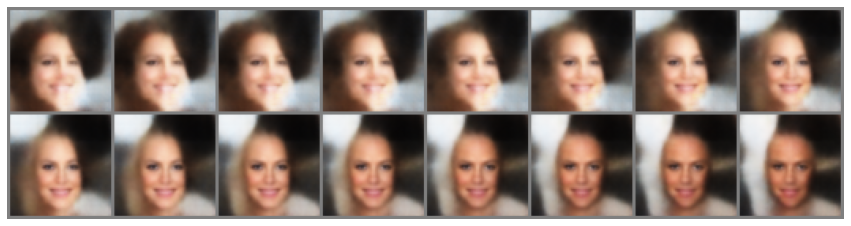

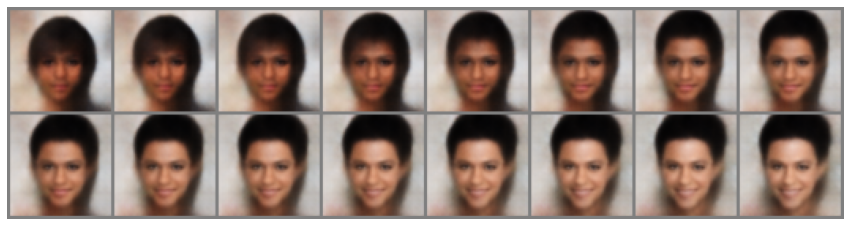

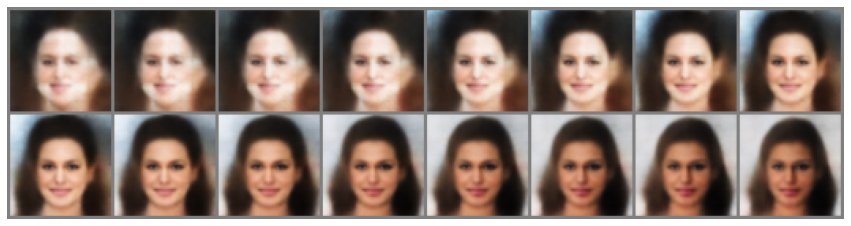

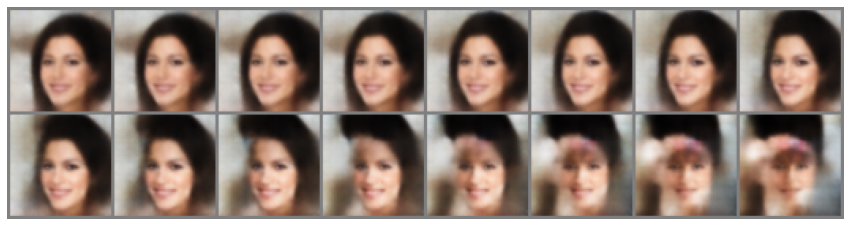

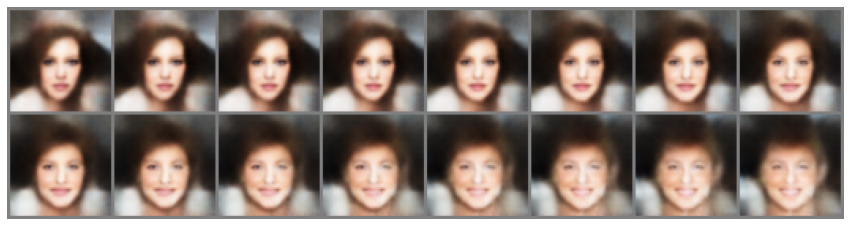

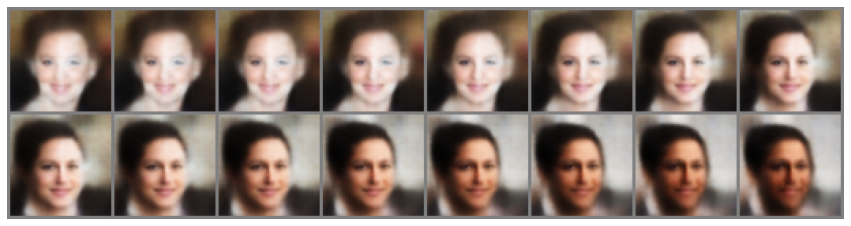

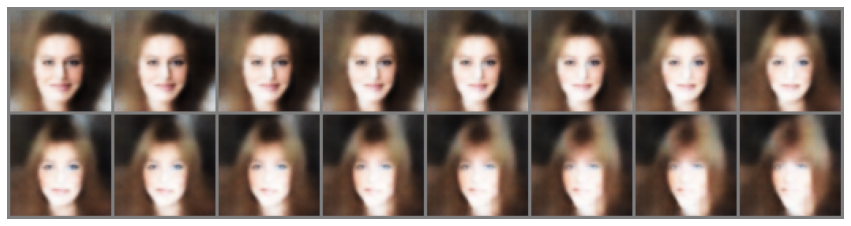

In [24]:
def latent_interpolation(n=16, iters=10):
    iter_dl = iter(DL)
    for i in range(iters):
        ans = []

        with torch.no_grad():
            image = next(iter_dl)[:2].to(device)

            a1, z, mu, std = m1(image) 

            for i in range(n):
                alpha = i / (n - 1)

                zz = (1 - alpha) * z[0] + alpha * z[1]

                ans.append(m1.sample(zz.unsqueeze(0)).cpu().data)

        plt.figure(figsize=(15, 15))
        x_show = make_grid(torch.cat(ans), nrow=n//2, normalize=False)
        plot_img(x_show, t_invnormalize)
        plt.show()
        
    
        
latent_interpolation()

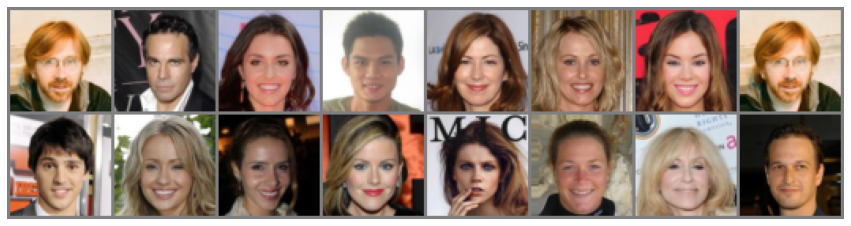

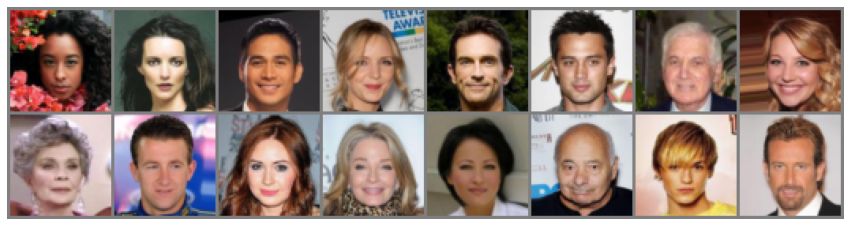

In [25]:
def explore_z(path):
    images = []
    z_s = []
    
    with torch.no_grad():
        while True:
            image = next(iter(DL)).to(device)

            a, z, mu, std = m1(image)

            if len(images) == 0:
                images = image.cpu().data
                z_s = z.cpu().data
            else:
                images = torch.cat([images, image.cpu().data], dim=0)
                z_s = torch.cat([z_s, z.cpu().data], dim=0)
            
            if images.shape[0] > 200:
                break
                
        image = transform(Image.open(path))[:3].unsqueeze(0).to(device)
        
        a, z, mu, std = m1(image)
        z = z.cpu().data
        
        z_s = ((z_s - z[0])**2).sum(dim=1)
        
    kek = images[z_s.argsort()[:16]]
                
    plt.figure(figsize=(15, 15))
    x_show = make_grid(kek, nrow=8, normalize=False)
    plot_img(x_show, t_invnormalize)
    plt.show()
        
explore_z('E:/programming/hse/GM/last_hw/111.png')
explore_z('E:/programming/hse/GM/last_hw/222.png')


## first FID

In [26]:
# def generate_images_output_m1(n, z=None):
#     for j in range(5):
#         z = torch.randn(n, 64).to(device)
        
#         with torch.no_grad():
#             images = m1.sample(z).cpu().data
        
#         for i, image in enumerate(images):
#             utils.save_image(
#                 image.cpu().data,
#                 "E:/programming/hse/GM/last_hw/kok/{}.png".format(i + j * 1000),
#                 normalize=True,
#                 range=(-1, 1)
#             )
        
# # 500 samples
# generate_images_output_m1(100)

# from fid_score import fid_score
# fid = fid_score.FidScore(['E:/programming/hse/GM/last_hw/data/celeba/img_align_celeba', 'E:/programming/hse/GM/last_hw/kok'], 'cuda', 16)
# score = fid.calculate_fid_score()

score = 166.36475729808444
score

166.36475729808444

## second FID

In [27]:
# from torchmetrics.image.fid import FrechetInceptionDistance

# def generate_images_returned_m1(n, z=None):
#     z = torch.randn(n, 64).to(device)
    
#     with torch.no_grad():
#         images = m1.sample(z).cpu().data

#     return images

# # 500 samples
# real = next(iter(DataLoader(dataset, batch_size=500, shuffle=True)))
# fake = generate_images_returned_m1(500)

# fid = FrechetInceptionDistance(feature=64)
# fid.update(torch.floor((real / 2 + 1) * 255).type(torch.uint8), real=True)
# fid.update(torch.floor((fake / 2 + 1) * 255).type(torch.uint8), real=False)
# score = fid.compute()

score = 2.7141
score

2.7141

### Задача 3 (6/10 балла). 

#### Задача 3.1 (4/10 балла) Построить и обучить VAPNEV на CelebA 64x64

Здесь нужно прочитать [статью про VAPNEV](https://arxiv.org/pdf/1611.05209.pdf), обучить его до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

#### Задача 3.2 (2/10 балла). Построить и обучить conditional VAPNEV на CelebA 64x64

Вроде понятно из текста задачи. Что такое conditional VAPNEV, читайте в статье

In [28]:
# YOUR CODE HERE

### Задача 4. (1/10 балла) Анализ

* Анализ латентного пространства и визуально качественный результат - **1 балл**
1. Посмотрите у какой модели получается лучшая интерполяция в латентном пространстве
2. Попробуйте взять внешнюю картинку (не из селебы), отмапить ее с латентное пространство и покажите ближайшие к ней.
3. Покажите самый смешной результат генерации который у вас получался

### Сделал исследование в соответствующих ячейках под имплементированными моделями.
__Вывод__: В латенте лучше из двух моделей справляется Glow, каждая точка выглядит как реальное лицо, медленно меняющееся. VAE же в этом случае просто морфит изображения как в фотошопе. Это заметно на всех примерах.

Маппинг рандомной картинки также представлен в работе в соответствующих ячейках.

Мем отображен в отчете.

### Задача 0. Отчет

Чтобы получить полный балл за каждый из пунктов вам нужно включить в отчет (который сдатеся отдельно в виде pdf) примеры (лучше - много примеров) генерации вашей модели. 

Сравните результаты разных моделей, попробуйте обьяснить почему одна сработала лучше чем другая.